<a href="https://colab.research.google.com/github/nvhieu0163/ComparativeOpinionMining_KLTN2023/blob/main/1_CSI_using_BiLSTM_RNN_GRU_trinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py_vncorenlp
!pip install transformers
!pip install tokenizers

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.9 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=dfcfac5939969baa741e5e68c02e9d7eb8bc3afc6d25aaf3364b5d6077d9b641
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import sys

In [ ]:
import py_vncorenlp
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/NCKH_KLTN/Thuc_nghiem/vn_corenlp_2')

In [ ]:
cd "/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final"

/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final


In [ ]:
df125 = pd.read_csv("file125_last_update.csv")
df34 = pd.read_csv("file34_last_update.csv")

## Nhị phân

In [ ]:
df_total =  pd.concat([df125, df34], ignore_index =  True)

# 3 labels
df_total.loc[df_total["CSI"] == 1, "CSI"] = 2   # gradable comparative là 2
df_total.loc[df_total["CSI"] == 3, "CSI"] = 2   # non comparative là 0
df_total.loc[df_total["CSI"] == 4, "CSI"] = 1   # non gradable comparative là 1

<Axes: >

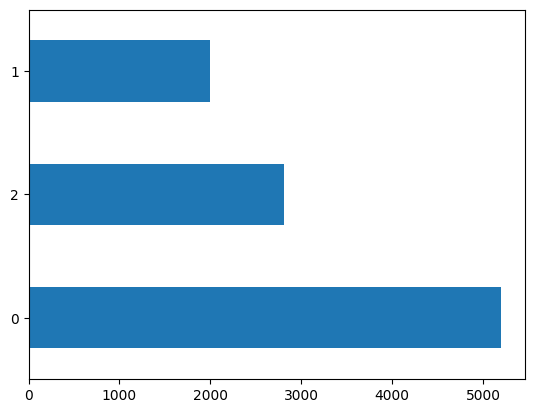

In [ ]:
df_total["CSI"].value_counts().plot.barh()

In [ ]:
token_main = []
for stc in df_total["main"]:
    a = rdrsegmenter.word_segment(stc)
    assert len(a) == 1, 'Độ dài câu văn khác 1'
    token_main.append(a[0])
df_total["main_token"] = token_main

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_total.main_token, df_total.CSI, test_size=0.2, random_state=42)

### Using BiLSTM + RNN

Data preprocessing

In [ ]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
VOCAB_SIZE = 6000
max_length = 160
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
train_sequences =  tokenizer.texts_to_sequences(X_train)
test_sequences =  tokenizer.texts_to_sequences(X_test)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating="post", padding="post")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating="post", padding="post")

In [ ]:
padded_train_sequences.shape

(8000, 160)

In [ ]:
data_vocab_size = len(tokenizer.word_index) + 1
print(data_vocab_size)

4091


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

Build model

In [ ]:
!pip install tensorflow-addons

  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, RNN, GlobalAveragePooling2D, Softmax, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# from keras.src import backend

In [ ]:
EPOCHS = 10
# INIT_LR = 1e-4
# MAX_LR = 1e-2

In [ ]:
input_dim = data_vocab_size
embedding_dim = 4096
dropout_threshold = 0.3

In [ ]:
LSTM_model = Sequential()

# Add embedding layer, input_length = max_length
LSTM_model.add(Embedding(input_dim = input_dim, output_dim = 4096))
# Add BiLSTM
LSTM_model.add(Bidirectional(LSTM(units=512, dropout = dropout_threshold, return_sequences=False)))

# LSTM_model.add(SimpleRNN(2048))
# LSTM_model.add(Flatten())
# LSTM_model.add(Dropout(0.3))
# LSTM_model.add(Dense(2048, activation = 'relu'))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(1024, activation = 'relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(512, activation = 'relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(64, activation = 'relu'))
LSTM_model.add(Dense(3, activation = 'softmax'))

adam = Adam(learning_rate = 0.001)

In [ ]:
LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 4096)        16756736  
                                                                 
 bidirectional_8 (Bidirecti  (None, 1024)              18878464  
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=3, average='macro')]
LSTM_model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = metrics)


In [ ]:
LSTM_model.fit(padded_train_sequences, y_train, epochs = EPOCHS)

Epoch 1/10
250/250 [==============================] - 61s 229ms/step - loss: 0.7319 - categorical_accuracy: 0.7038 - f1_score: 0.6516
Epoch 2/10
250/250 [==============================] - 49s 196ms/step - loss: 0.5168 - categorical_accuracy: 0.8086 - f1_score: 0.7748
Epoch 3/10
250/250 [==============================] - 48s 192ms/step - loss: 0.3879 - categorical_accuracy: 0.8571 - f1_score: 0.8312
Epoch 4/10
250/250 [==============================] - 47s 189ms/step - loss: 0.3008 - categorical_accuracy: 0.8878 - f1_score: 0.8654
Epoch 5/10
250/250 [==============================] - 47s 189ms/step - loss: 0.2289 - categorical_accuracy: 0.9166 - f1_score: 0.8994
Epoch 6/10
250/250 [==============================] - 47s 190ms/step - loss: 0.1768 - categorical_accuracy: 0.9376 - f1_score: 0.9255
Epoch 7/10
250/250 [==============================] - 47s 189ms/step - loss: 0.1299 - categorical_accuracy: 0.9556 - f1_score: 0.9464
Epoch 8/10
250/250 [==============================] - 48s 191m

In [ ]:
LSTM_model.evaluate(padded_test_sequences, y_test)
preds = LSTM_model.predict(padded_test_sequences)
p = tf.math.argmax(preds, 1).numpy()
y = tf.math.argmax(y_test, 1).numpy()
print(classification_report(y, p, digits=4))

63/63 [==============================] - 4s 61ms/step
              precision    recall  f1-score   support

           0     0.8623    0.8790    0.8706      1033
           1     0.6442    0.7053    0.6734       380
           2     0.8173    0.7394    0.7764       587

    accuracy                         0.8050      2000
   macro avg     0.7746    0.7745    0.7734      2000
weighted avg     0.8077    0.8050    0.8055      2000



In [ ]:
# from keras.src import backend
# class MinimalRNNCell(keras.layers.Layer):

#     def __init__(self, units, **kwargs):
#         self.units = units
#         self.state_size = units
#         super(MinimalRNNCell, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
#                                       initializer='uniform',
#                                       name='kernel')
#         self.recurrent_kernel = self.add_weight(
#             shape=(self.units, self.units),
#             initializer='uniform',
#             name='recurrent_kernel')
#         self.built = True

#     def call(self, inputs, states):
#         prev_output = states[0]
#         h = backend.dot(inputs, self.kernel)
#         output = h + backend.dot(prev_output, self.recurrent_kernel)
#         return output, [output]

# cell = MinimalRNNCell(512)

In [ ]:
GRU_model = Sequential()

# Add embedding layer, input_length = max_length
GRU_model.add(Embedding(input_dim = input_dim, output_dim = 4096))
# Add BiLSTM
GRU_model.add(Bidirectional(GRU(units=512, dropout = dropout_threshold, return_sequences=False)))

# GRU_model.add(SimpleRNN(2048))
# GRU_model.add(Flatten())
# GRU_model.add(Dropout(0.3))
# GRU_model.add(Dense(2048, activation = 'relu'))
# GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(1024, activation = 'relu'))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(512, activation = 'relu'))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(64, activation = 'relu'))
GRU_model.add(Dense(3, activation = 'softmax'))

adam = Adam(learning_rate = 0.0001)

In [ ]:
GRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 4096)        16756736  
                                                                 
 bidirectional_5 (Bidirecti  (None, 1024)              14161920  
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=3, average='macro')]
GRU_model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = metrics)

In [ ]:
GRU_model.fit(padded_train_sequences, y_train, epochs = EPOCHS)

Epoch 1/10
250/250 [==============================] - 52s 186ms/step - loss: 0.8354 - categorical_accuracy: 0.6280 - f1_score: 0.5226
Epoch 2/10
250/250 [==============================] - 38s 153ms/step - loss: 0.5459 - categorical_accuracy: 0.7899 - f1_score: 0.7496
Epoch 3/10
250/250 [==============================] - 38s 152ms/step - loss: 0.4562 - categorical_accuracy: 0.8244 - f1_score: 0.7917
Epoch 4/10
250/250 [==============================] - 37s 147ms/step - loss: 0.3960 - categorical_accuracy: 0.8510 - f1_score: 0.8244
Epoch 5/10
250/250 [==============================] - 37s 147ms/step - loss: 0.3423 - categorical_accuracy: 0.8740 - f1_score: 0.8518
Epoch 6/10
250/250 [==============================] - 37s 146ms/step - loss: 0.3174 - categorical_accuracy: 0.8813 - f1_score: 0.8598
Epoch 7/10
250/250 [==============================] - 36s 144ms/step - loss: 0.2851 - categorical_accuracy: 0.8923 - f1_score: 0.8724
Epoch 8/10
250/250 [==============================] - 37s 146m

In [ ]:
GRU_model.evaluate(padded_test_sequences, y_test)
preds = GRU_model.predict(padded_test_sequences)
p = tf.math.argmax(preds, 1).numpy()
y = tf.math.argmax(y_test, 1).numpy()
print(classification_report(y, p, digits=4))

63/63 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

           0     0.8526    0.8732    0.8627      1033
           1     0.6491    0.6816    0.6650       380
           2     0.7808    0.7223    0.7504       587

    accuracy                         0.7925      2000
   macro avg     0.7608    0.7590    0.7594      2000
weighted avg     0.7929    0.7925    0.7922      2000

